# Analysis of Proportional-Integral Controller

## Learning Objectives

In this notebook, we will use a mathematical model for the TCLab to design and analyze a PI controller.

After studying this notebook and completing the activities, you will be able to:
* Agument dynamic system model with PI feedback control law to predict closed loop dynamics
* Analyze stability of a (linear) system
* Perform senstivity analysis to tune controller

First review the [proportional only controller notes](../tclab/04-TCLab-P-Controller-Analysis.ipynb) for modeling details.


## Proporational-Integral Control Law

We will consider the proporational control law:

$$
u_{1} = u^*_{1} - K_p (T_{S,1}-T_{set}) - K_i \int_{0}^{t} (T_{S,1}(t) - T_{set}) dt
$$

Here, $K_p > 0$ is the proportional gain, $K_i > 0$ is the integral gain, and $T_{S,1}-T_{set}$ is the tracking error.

## Closed-Loop Dynamics

How can we model the integral in the control law? Let's add a new state to our model for the integral:
$$
\begin{align}
C^H_p\frac{dT^*_{H,1}}{dt} & = -U_a T^*_{H,1} + U_b(T^*_{S,1} - T^*_{H,1}) - \alpha P_1 K_p T^*_{S,1} - \alpha P_1 K_i I\\
C^S_p\frac{dT^*_{S,1}}{dt} & = U_b(T^*_{H,1} - T^*_{S,1}) \\
\frac{dI}{dt} &= T^{*}_{S,1}
\end{align}
$$

Let's collect similar terms:

$$
\begin{align}
\frac{dT^*_{H,1}}{dt} & = \left(-\frac{U_a + U_b}{C^H_p} \right)  T^*_{H,1} + \left(\frac{U_b - \alpha P_1 K_p}{C_p^H} \right) T^*_{S,1} + \left(\frac{- \alpha P_1 K_I}{C_p^H} \right) I  \\
\frac{dT^*_{S,1}}{dt} & = \left(\frac{U_b}{C_p^S} \right) T^*_{H,1} + \left(-\frac{U_b}{C_p^S} \right) T^*_{S,1} \\
\frac{dI}{dt} &= T^{*}_{S,1}
\end{align}
$$

Finally, we can write this as a linear differential equation in matrix form:

$$
\begin{align}
\frac{d}{dt}\underbrace{\begin{bmatrix} T^*_{H,1} \\ T^*_{S,1} \\ I \end{bmatrix}}_\mathbf{x} & = 
\underbrace{\begin{bmatrix} -\frac{U_a+U_b}{C^H_p} & \frac{U_b - \alpha P_1 K_p}{C^H_p} & \frac{- \alpha P_1 K_i}{C^H_p} \\ 
\frac{U_b}{C^S_p} & - \frac{U_b}{C^S_p} & 0 \\
0 & 1 & 0 \end{bmatrix}}_\mathbf{A} 
\underbrace{\begin{bmatrix} T^*_{H,1} \\ T^*_{S,1} \\ I \end{bmatrix}}_\mathbf{x} \\
\\
\underbrace{\begin{bmatrix} T^*_{S,1}\end{bmatrix}}_\mathbf{y} & = 
\underbrace{\begin{bmatrix}0 & 1 & 0 \end{bmatrix}}_\mathbf{C} 
\underbrace{\begin{bmatrix} T^*_{H,1} \\ T^*_{S,1} \\ I \end{bmatrix}}_\mathbf{x}
\end{align}
$$

This system describes the closed loop dynamics. Take a few minutes to compare to the model for [open loop dynamics](../notebooks/02.05-Second-Order.ipynb). Notice the above model does not include $u$ or $\mathbf{B}$ because the control law is embedded in the closed loop model.



## Numeric Simulation 

Let's simulate the closed loop response.

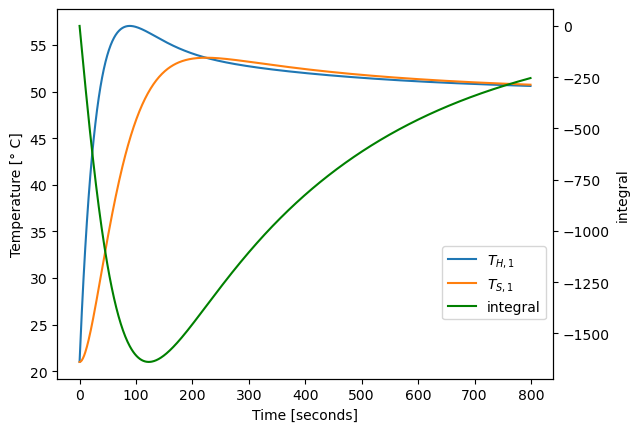

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

# parameters
T_amb = 21 # deg C
alpha = 0.00016 # watts / (units P1 * percent U1)
P1 = 100 # P1 units
U1 = 50 # steady state value of u1 (percent)

# fiited parameters (see previous lab)
Ua = 0.0261 # watts/deg C
Ub = 0.0222 # watts/deg C
CpH = 1.335 # joules/deg C
CpS = 1.328 # joules/deg C

t_final = 800
t_step = 1
t_expt = np.arange(0,t_final,t_step)


T_set = 50

def simulate_response(Kp=2.0, Ki=0.1):
    """
    
    """
    A_PI = np.array([[-(Ua + Ub)/CpH, (Ub - alpha*P1*Kp)/CpH, -alpha*P1*Ki/CpH], 
                [Ub/CpS, -Ub/CpS, 0],
                [0, 1, 0]])


    # model solution
    def deriv3(t, y):
        return A_PI @ y
    soln_P = solve_ivp(deriv3, [min(t_expt), max(t_expt)], [T_amb - T_set, T_amb-T_set, 0], t_eval=t_expt)

    fig, ax1 = plt.subplots()

    ax1.plot(soln_P.t, soln_P.y[0] + T_set,label='$T_{H,1}$')
    ax1.plot(soln_P.t, soln_P.y[1] + T_set,label='$T_{S,1}$')
    ax1.set_xlabel('Time [seconds]')
    ax1.set_ylabel('Temperature [° C]')

    ax2 = ax1.twinx()
    ax2.plot(soln_P.t, soln_P.y[2] ,label='integral', color='green')
    ax2.set_ylabel('integral')

    #fig.legend(['T1H','T1S','integral'])
    fig.legend(bbox_to_anchor=(0.9, 0.4))
    plt.show()

simulate_response(Kp=2.5, Ki=0.01)

Perform a simple sensitivity analysis and answer the following discussion questions:
* What happens with small and large $K_p$ values? Does the solution overshoot or undershoot? How long does it take to reach the set point?
* What happens with small and large $K_i$ values?

## Stability Analysis

Let's inspect the eigenvalues of $\mathbf{A}$.

In [2]:
# Eigendecomposition analysis
from scipy.linalg import eig

def calc_eig(Kp,Ki,verbose=True):

    A_PI = np.array([[-(Ua + Ub)/CpH, (Ub - alpha*P1*Kp)/CpH, -alpha*P1*Ki/CpH], 
                [Ub/CpS, -Ub/CpS, 0],
                [0, 1, 0]])
    
    w, vl = eig(A_PI)

    if verbose:
        for i in range(len(w)):
            print("Eigenvalue",i,"=",w[i])
            print("Eigenvector",i,"=",vl[:,i],"\n")

    return w

calc_eig(Kp=1.5,Ki=0.01)

Eigenvalue 0 = (-0.03764573038129279+0j)
Eigenvector 0 = [-0.04704547  0.03757743 -0.99818568] 

Eigenvalue 1 = (-0.009845188625015502+0j)
Eigenvector 1 = [-0.00404676 -0.00984463  0.99994335] 

Eigenvalue 2 = (-0.005405723744470089+0j)
Eigenvector 2 = [-0.0036576  -0.00540561  0.9999787 ] 



array([-0.03764573+0.j, -0.00984519+0.j, -0.00540572+0.j])

Here are rules for interpretting the eigenvalues and eigenvectors:
* If all of the real components of the eigenvalues are negative, the system is stable and will return to the steady state ($T^*_{S,1} \rightarrow 0$, $T^*_{H,1} \rightarrow 0$).
* The eigenvectors corresponding to any eigenvalues with a positive real component shows the direction of exponential growth.
* If any of the eigenvalues have non-zero imaginary components, the system osciallates.

Let's perform a sensitivity analysis to see how the eigenvalues change.

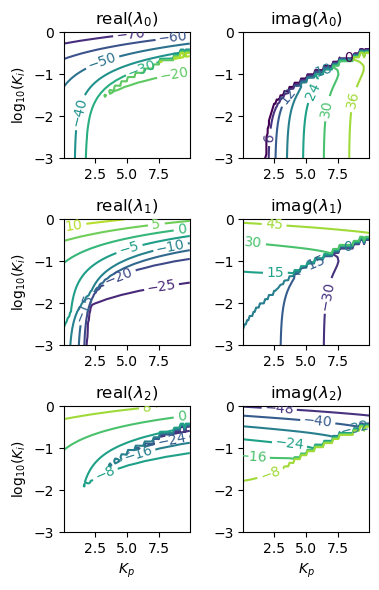

In [3]:
Kp_range = np.arange(0.1,10,0.1)
Ki_range = np.arange(-3,0.1,0.1)
xv, yv = np.meshgrid(Kp_range, Ki_range)

# store eigenvalues in 3D array
s3 = (len(Ki_range),len(Kp_range),3)
s2 = (len(Ki_range),len(Kp_range))
ev = np.zeros(s3, dtype=complex)
positive_real_eig = np.zeros(s2)
nonzero_imag_eig = np.zeros(s2)

for i in range(len(Ki_range)):
    for j in range(len(Kp_range)):
        ev[i,j,:] = calc_eig(xv[i,j], np.power(10,yv[i,j]), verbose=False)[:]
        positive_real_eig[i,j] = sum(np.real(ev[i,j,:]) >= -1E-9)
        nonzero_imag_eig[i,j] = sum(np.abs(np.imag(ev[i,j,:])) >= 1E-9)


fig, axs = plt.subplots(3,2)
fig.set_figheight(6)
fig.set_figwidth(4)


scale = 1000

for i in range(3):
    CS = axs[i,0].contour(xv,yv,np.real(ev[:,:,i])*scale)
    axs[i,0].set_box_aspect(1)
    axs[i, 0].clabel(CS, inline=True, fontsize=10)
    axs[i, 0].set_title('real($\lambda_'+str(i)+'$)')
    axs[i, 0].set_ylabel('log$_{10}$($K_i$)')

    CS = axs[i,1].contour(xv,yv,np.imag(ev[:,:,i])*scale)
    axs[i,1].set_box_aspect(1)
    axs[i, 1].clabel(CS, inline=True, fontsize=10)
    axs[i, 1].set_title('imag($\lambda_'+str(i)+'$)')
    

    if i == 2:
        axs[i, 0].set_xlabel('$K_p$')
        axs[i, 1].set_xlabel('$K_p$')

plt.tight_layout()
plt.show()



These six subplots show how the real (right) and imaginary (left) components of the three eigenvalues (rows) change as a function of $K_p$ and $K_i$. While these plots are informative, they are a little difficult to interpret.

The code below plots the number of positive real eigenvalue componenets (left) and nonzero imaginary eigenvalue components (right). Yellow regions are 2 and blue regions are 0. Thus, choosing $K_p$ and $K_i$ values in the blue region on the left ensures the controller is stable. Likewise, selecting the blue region on the right ensures no oscillations. The exact region of these transitions depends on our assumptions about the mathematical model (and measurement noise). We are hoping the model is good enough to use this plot as a guideline for tuning the controller.

<Figure size 640x480 with 0 Axes>

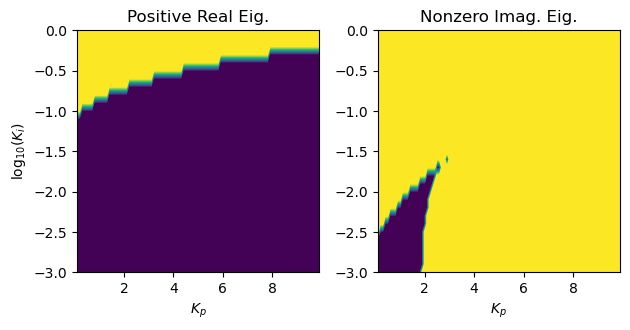

In [4]:
plt.figure()
fig, axs = plt.subplots(1,2)

axs[0].set_box_aspect(1)
cs = axs[0].contourf(xv,yv,positive_real_eig, levels=100)
#cbar = plt.colorbar(cs)
axs[0].set_xlabel('$K_p$')
axs[0].set_ylabel('log$_{10}$($K_i$)')
axs[0].set_title('Positive Real Eig.')

axs[1].set_box_aspect(1)
cs = axs[1].contourf(xv,yv,nonzero_imag_eig, levels=100)
#cbar = plt.colorbar(cs)
axs[1].set_xlabel('$K_p$')
#axs[1].set_ylabel('log$_{10}$($K_i$)')
axs[1].set_title('Nonzero Imag. Eig.')

plt.tight_layout()
plt.show()

## Simulate Performance with TC Lab

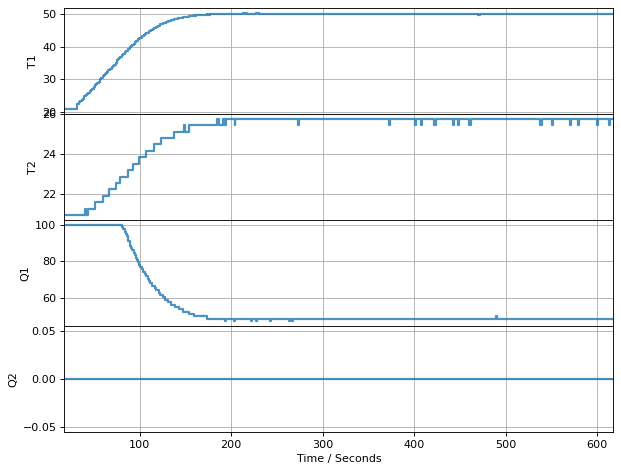

TCLab Model disconnected successfully.


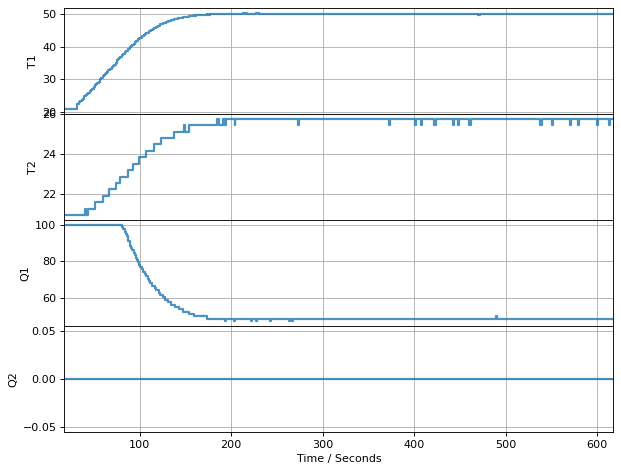

In [5]:
def PI_naive(Kp=4, Ki=0.01, MV_bar=0, antiwindup=True):
    """ Basic proportional-integral controller 

    Arguments:
        Kp: proportional gain
        MV_bar: steady-state value for manipulated variable

    """
    # Minimum and maximum bounds for manipulated variables
    MV_min = 0
    MV_max = 100

    # Initialize with MV_bar
    MV = MV_bar

    # Initialize integral
    I = 0

    # Set limits for integral windup protection
    I_max = 100
    I_min = -100

    while True:
        t_step, SP, PV, MV = yield MV
        e = PV - SP # calculate error
        I += t_step*e # apply integral
        if antiwindup:
            I = max(I_min, min(I_max, I)) # Apply bounds to prevent integral wind-up
        MV = MV_bar - Kp*e - Ki*I # Apply control law
        MV = max(MV_min, min(MV_max, MV)) # Apply manipulated variable upper and lower bounds

%matplotlib inline
from tclab import setup, clock, Historian, Plotter

# Initialize in simulation mode
TCLab = setup(connected=False, speedup = 20)

SP = 50 # set point, deg C
tfinal = 600 # simulation horizon, seconds
t_step = 1 # time step, seconds
u_star = Ua*(SP-T_amb) / (alpha*100) # u at steady-state
print("MV_bar =",u_star)

# create control loop
controller1 = PI_naive(MV_bar=u_star)
controller1.send(None)

with TCLab() as lab:
    h = Historian(lab.sources)
    p = Plotter(h, tfinal)
    for t in clock(tfinal, t_step):
        PV = lab.T1                                     # measure the the process variable
        MV = lab.U1                                     # get manipulated variable
        MV = controller1.send([t_step, SP, PV, MV])     # PI control to determine the MV
        lab.Q1(MV)                                      # set the heater power
        p.update()                                      # log data